# What is important for stopping power?
This notebook is designed to study what factors are the most important in predicting stopping power

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge, LassoLars
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import pickle as pkl

## Load in Training and Run Data
These were generated by previous notebooks

In [2]:
train_data = pkl.load(open('training_set.pkl', 'rb'))

Read in the column labels

In [3]:
featurizers = pkl.load(open('featurizers.pkl', 'rb'))
X_cols = sum([f.feature_labels() for f in featurizers], [])

Assign labels to different groups

In [4]:
input_group = dict()
input_group['ion-ion repulsion'] = ['ion-ion repulsion',]
input_group['electron density'] = [x for x in X_cols if 'density' in x]
input_group['local structure'] = [x for x in X_cols if 'AGNI' in x]

## Train a Model
Train a LASSO model.

In [5]:
scaler = MinMaxScaler()

In [6]:
X_scaled = MinMaxScaler().fit_transform(train_data[X_cols])

In [7]:
model = LassoLars(max_iter=13, alpha=1e-10, fit_intercept=True).fit(train_data[X_cols], train_data['force'])

## Does this model actually work?
Before interpreting features, we need to see if the model actually captures the features it claims to

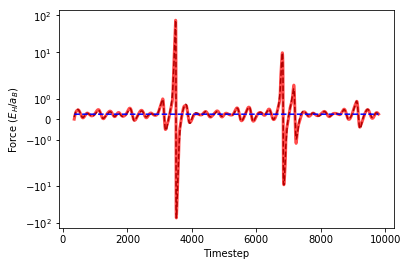

In [8]:
fig, ax = plt.subplots()

ax.plot(train_data['timestep'], train_data['force'], 'k--')
ax.plot(train_data['timestep'], model.predict(train_data[X_cols]), 'r', alpha=0.7, lw=3)

ax.plot(train_data['timestep'], [train_data['force'].mean(), ]*len(train_data), 'b--')

ax.set_yscale('symlog')

ax.set_ylabel('Force ($E_H / a_B$)')
ax.set_xlabel('Timestep')

*Finding*: Yes, it fits the data on a large scale well

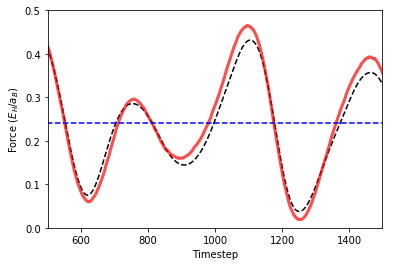

In [9]:
fig, ax = plt.subplots()

ax.plot(train_data['timestep'], train_data['force'], 'k--')
ax.plot(train_data['timestep'], model.predict(train_data[X_cols]), 'r', alpha=0.7, lw=3)

ax.plot(train_data['timestep'], [train_data['force'].mean(), ]*len(train_data), 'b--')

ax.set_ylim(0, 0.5)
ax.set_xlim(500, 1500)

ax.set_ylabel('Force ($E_H / a_B$)')
ax.set_xlabel('Timestep')

*Finding*: And it does well on the small scale forces

## Assess Order in Which Features Were Added
The LASSO algorithm I chose works by forward selection. It starts with the most important feature, then adds the next, and so on. This gives us an idea of relative importance of each feature

In [10]:
for i in range(1,6):
    print('Step %d:'%i, ', '.join([X_cols[x] for x in np.nonzero(model.coef_path_[:,i])[0].tolist()]))

Step 1: ion-ion repulsion
Step 2: AGNI eta=2.89e+00, ion-ion repulsion
Step 3: AGNI eta=1.88e+00, ion-ion repulsion
Step 4: AGNI eta=1.88e+00, ion-ion repulsion
Step 5: density t=1.000000, AGNI eta=1.88e+00, ion-ion repulsion


*Finding*: The most important single feature is ion-ion repulsion, followed by structural features, and then the charge density

### Which features are *not* selected?
This will give us an idea what is irrelevent/redundant

In [11]:
feature_scores = pd.DataFrame(list(zip(X_cols, model.coef_)), columns=['name','coefficient'])

In [12]:
feature_scores['abs_coefficient'] = feature_scores['coefficient'].apply(abs)

In [13]:
feature_scores.sort_values('abs_coefficient', ascending=False, inplace=True)

In [14]:
feature_scores

,name,coefficient,abs_coefficient
8,AGNI eta=1.23e+00,9.307722,9.307722
10,AGNI eta=2.89e+00,1.379041,1.379041
11,AGNI eta=4.43e+00,0.994917,0.994917
15,ion-ion repulsion,0.474986,0.474986
9,AGNI eta=1.88e+00,0.322777,0.322777
0,density t=1.000000,-0.089214,0.089214
2,density t=-1.000000,0.055532,0.055532
4,density t=-3.000000,0.029995,0.029995
3,density t=-2.000000,-0.019923,0.019923
5,density t=-4.000000,0.008436,0.008436


AGNI features and some charge densities are not selected. Interestingly, the magnitude of the importance of charge densities generally drops off with time from present and the most important feature is the charge density *ahead* of the projectile.

## How much of the force at any one step is due to each component?
What explains force acting on each particle the best

In [15]:
group_contr = dict()
for group, cols in input_group.items():
    # Get the input array with only my attributes
    X_temp = np.zeros_like(train_data[X_cols])
    for col in cols:
        col_id = X_cols.index(col)
        X_temp[:,col_id] = train_data[col]
        
    # Compute contribution
    group_contr[group] = np.dot(X_temp, model.coef_)

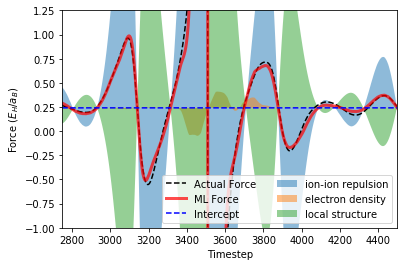

In [16]:
fig, ax = plt.subplots()

ax.plot(train_data['timestep'], train_data['force'], 'k--', label='Actual Force')
ax.plot(train_data['timestep'], model.predict(train_data[X_cols]), 'r', alpha=0.7, lw=3, label='ML Force')

for group, contr in group_contr.items():
    
    ax.fill_between(train_data['timestep'], contr + model.intercept_, model.intercept_, alpha=0.5, label=group)

ax.plot(train_data['timestep'], [model.intercept_, ]*len(train_data), 'b--', label='Intercept')

ax.legend(ncol=2)

ax.set_ylim(-1, 1.25)
ax.set_xlim(2750, 4500)

ax.set_ylabel('Force ($E_H / a_B$)')
ax.set_xlabel('Timestep')

*Finding*: The bulk of the force is due to the ion-ion repulsion, offset by features related to the local environment. Charge density is only important near the cores

### How does each contribute to stopping power?

In [17]:
for group, contr in group_contr.items():
    print(group, contr.mean())
print('intercept', model.intercept_)

ion-ion repulsion 0.00161395296949
electron density -0.0011110939665
local structure -0.0011146455882
intercept 0.241162983235


In [18]:
# make sure the group contributions match the actual stopping power
print('Actual Stopping Power:', train_data['force'].mean())
print('My Stopping Power:', sum([x.mean() for x in group_contr.values()], model.intercept_))

*Finding*: Basically all the 'stopping power' is in the intercept. The model isn't really learning the effect of electron density on the stopping power, or any of these other factors. I suspect the 'stopping power' from ion-ion might be due to integration errors.

### What about for channels? 
Here, the ion-ion repulsion should be less important

In [19]:
channel_data = pkl.load(open('Al_channel.pkl', 'rb'))

In [20]:
lat_spacing = channel_data['atoms'][0].cell[0,0] / 4

In [21]:
channel_data.query('displacement >= %f and displacement <= %f'%(lat_spacing, lat_spacing * 3))

Contribute contributions

In [22]:
group_contr = dict()
for group, cols in input_group.items():
    # Get the input array with only my attributes
    X_temp = np.zeros_like(channel_data[X_cols])
    for col in cols:
        col_id = X_cols.index(col)
        X_temp[:,col_id] = channel_data[col]
        
    # Compute contribution
    group_contr[group] = np.dot(X_temp, model.coef_)

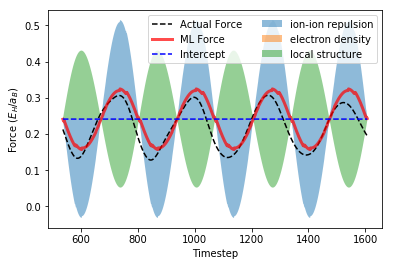

In [23]:
fig, ax = plt.subplots()

ax.plot(channel_data['timestep'], channel_data['force'], 'k--', label='Actual Force')
ax.plot(channel_data['timestep'], model.predict(channel_data[X_cols]), 'r', alpha=0.7, lw=3, label='ML Force')

for group, contr in group_contr.items():
    
    ax.fill_between(channel_data['timestep'], contr + model.intercept_, model.intercept_, alpha=0.5, label=group)

ax.plot(channel_data['timestep'], [model.intercept_, ]*len(channel_data), 'b--', label='Intercept')

ax.legend(ncol=2)

ax.set_ylabel('Force ($E_H / a_B$)')
ax.set_xlabel('Timestep')

Compute their effect on stopping power

In [24]:
for group, contr in group_contr.items():
    print(group, contr.mean())
print('intercept', model.intercept_)

ion-ion repulsion 2.6171598361e-05
electron density -0.000536621308308
local structure -7.5156325677e-08
intercept 0.241162983235


In [25]:
print('Actual Stopping Power:', channel_data['force'].mean())
print('My Stopping Power:', sum([x.mean() for x in group_contr.values()], model.intercept_))

Actual Stopping Power: 0.218318483881
My Stopping Power: 0.240652458369


*Finding*: The 'ion-ion' and 'local-environment' features do not contribute at all to the stopping power in this segment. This is not surprsing. Due to the symmetry of the lattice, the ion-ion repulsion and AGNI descriptors are equal and opposite at positions (x,0,0) and (-x,0,0) [where x is the fractional coordinate of the atom]. This is not true for charge density, but the effect is small as the charge density is a small effect. Note that this logic is only true for linear models.